In [172]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from ISLP import load_data
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import PolynomialFeatures

In [173]:
data = load_data('Auto')
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
x = data[['horsepower']]
y = data['mpg']

## Problema 1: No linealidad entre respuesta-factores

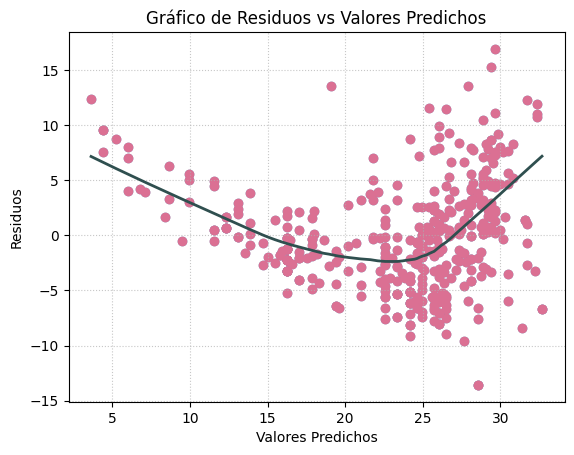

In [174]:
modelo = LinearRegression()
modelo.fit(x, y)
y_pred = modelo.predict(x)
residuos = y - y_pred

lowess_line = lowess(residuos, y_pred, frac=0.7) 

plt.scatter(y_pred, residuos, alpha=0.6)
plt.plot(lowess_line[:, 0], lowess_line[:, 1], color='darkslategrey', linewidth=2)

plt.scatter(y_pred, residuos, color = 'palevioletred')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs Valores Predichos')
plt.grid(linestyle=':', alpha=0.7)

La gráfica muestra un patrón curvo claro en los residuos, lo que indica que no se distribuyen de manera aleatoria alrededor de cero. Esto significa que la relación entre mpg y horsepower no es lineal, y el modelo lineal no captura adecuadamente la forma real de la relación.

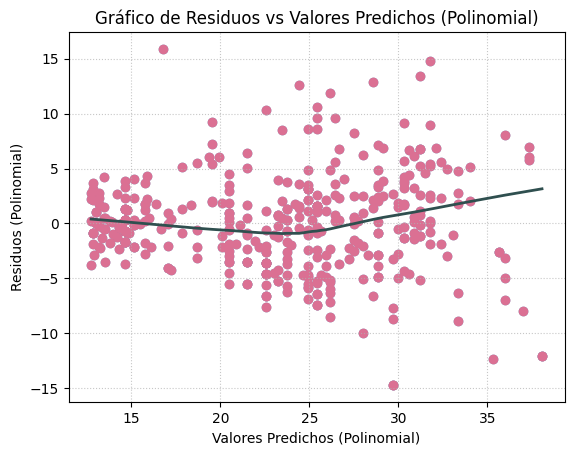

In [175]:
x_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)
modelo_poly = LinearRegression()
modelo_poly.fit(x_poly, y)
y_poly_pred = modelo_poly.predict(x_poly)
residuos_poly = y - y_poly_pred

lowess_line_poly = lowess(residuos_poly, y_poly_pred, frac=0.7)
plt.scatter(y_poly_pred, residuos_poly, alpha=0.6)
plt.plot(lowess_line_poly[:, 0], lowess_line_poly[:, 1], color='darkslategrey', linewidth=2)
plt.scatter(y_poly_pred, residuos_poly, color = 'palevioletred')
plt.xlabel('Valores Predichos (Polinomial)')
plt.ylabel('Residuos (Polinomial)')
plt.title('Gráfico de Residuos vs Valores Predichos (Polinomial)')
plt.grid(linestyle=':', alpha=0.7)

Aunque se muestra una mejora, la gráfica muestra un patrón curvo claro en los residuos todavía, lo que indica que no se distribuyen de manera aleatoria alrededor de cero. Esto significa que la relación entre mpg y horsepower y horsepower al cuadrado no es lineal, y el modelo lineal no captura adecuadamente la forma real de la relación.

## Problema 2: Correlación en errores

In [176]:
res = residuos

rho_1 = np.corrcoef(res[:-1], res[1:])[0, 1]
print("Correlación lag-1:", rho_1)

Correlación lag-1: 0.5397905087253315


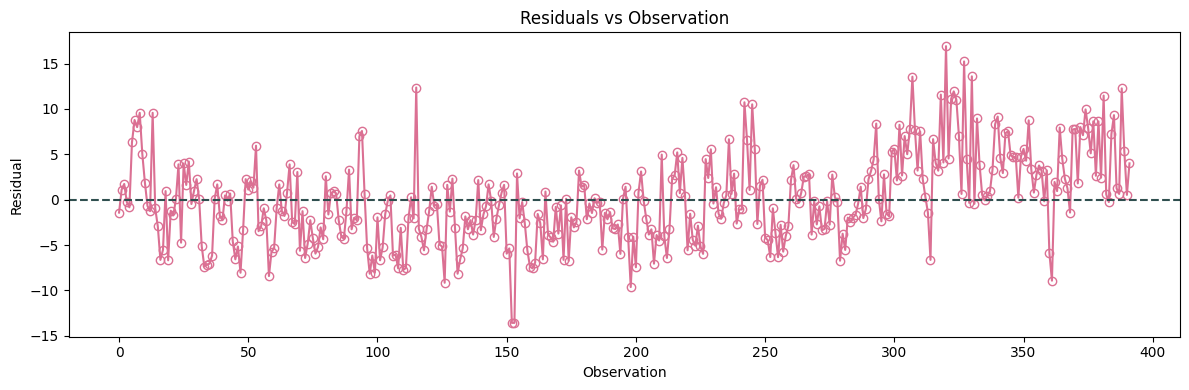

In [177]:
residuos = np.asarray(residuos).reshape(-1)
plt.figure(figsize=(12, 4))
plt.plot(
    residuos,
    marker='o',
    linestyle='-',
    color='palevioletred',
    markerfacecolor='none'
)
plt.axhline(0, linestyle='--', color='darkslategrey')
plt.title("Residuals vs Observation")
plt.xlabel("Observation")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()



La correlación entre los errores es 0.5397, lo que significa que los residuos no son independientes. En un modelo de regresión lineal, un valor tan alto indica que el modelo está dejando estructura sin explicar.

## Problema 3: Varianza no constante en errores

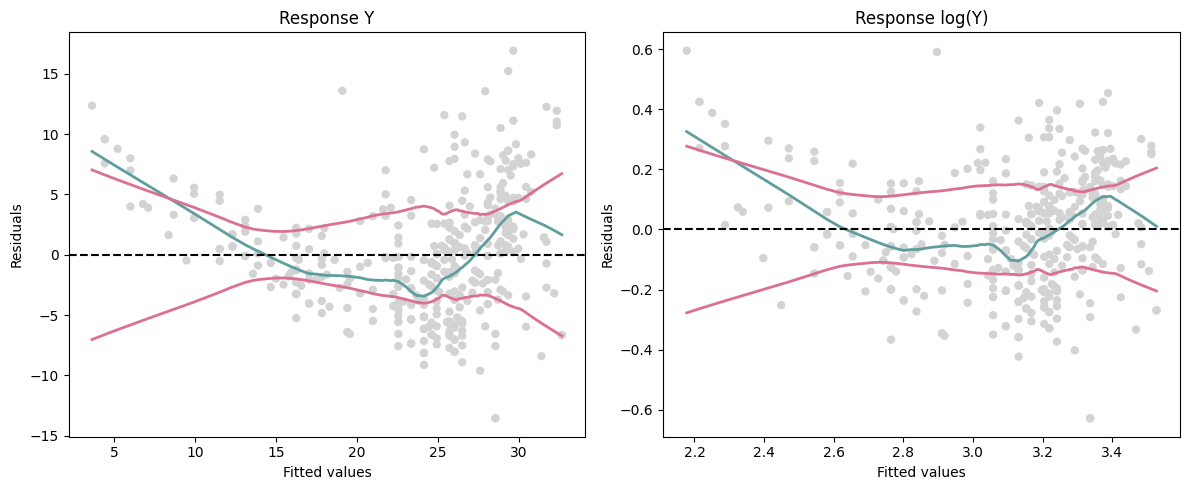

In [178]:
from statsmodels.nonparametric.smoothers_lowess import lowess

y_pred = y_pred.ravel()

loess_center_y = lowess(residuos, y_pred, frac=0.3, return_sorted=True)
loess_upper_y = lowess(np.abs(residuos), y_pred, frac=0.3, return_sorted=True)
loess_lower_y = loess_upper_y.copy()
loess_lower_y[:,1] = -loess_lower_y[:,1]

logy = np.log(y)
modelo_logy = LinearRegression()
modelo_logy.fit(x, logy)
fitted_logy = modelo_logy.predict(x).ravel()
resid_logy = logy - fitted_logy

loess_center_logy = lowess(resid_logy, fitted_logy, frac=0.3, return_sorted=True)
loess_upper_logy = lowess(np.abs(resid_logy), fitted_logy, frac=0.3, return_sorted=True)
loess_lower_logy = loess_upper_logy.copy()
loess_lower_logy[:,1] = -loess_lower_logy[:,1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuos, color="lightgray", edgecolors="none")
plt.plot(loess_center_y[:,0], loess_center_y[:,1], color="cadetblue", linewidth=2)
plt.plot(loess_upper_y[:,0], loess_upper_y[:,1], color="palevioletred", linewidth=2)
plt.plot(loess_lower_y[:,0], loess_lower_y[:,1], color="palevioletred", linewidth=2)
plt.axhline(0, linestyle="--", color="black")
plt.title("Response Y")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

plt.subplot(1, 2, 2)
plt.scatter(fitted_logy, resid_logy, color="lightgray", edgecolors="none")
plt.plot(loess_center_logy[:,0], loess_center_logy[:,1], color="cadetblue", linewidth=2)
plt.plot(loess_upper_logy[:,0], loess_upper_logy[:,1], color="palevioletred", linewidth=2)
plt.plot(loess_lower_logy[:,0], loess_lower_logy[:,1], color="palevioletred", linewidth=2)
plt.axhline(0, linestyle="--", color="black")
plt.title("Response log(Y)")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()


Como se puede ver en las gráficas anteriores, la varianza en ambos casos no es constante, lo que indica heterocedasticidad. Esto significa que la dispersión de los residuos cambia a lo largo de los valores predichos, violando el supuesto de homocedasticidad del modelo lineal y sugiriendo que el modelo no está capturando adecuadamente la estructura de los datos.

## Problema 4: Outliers

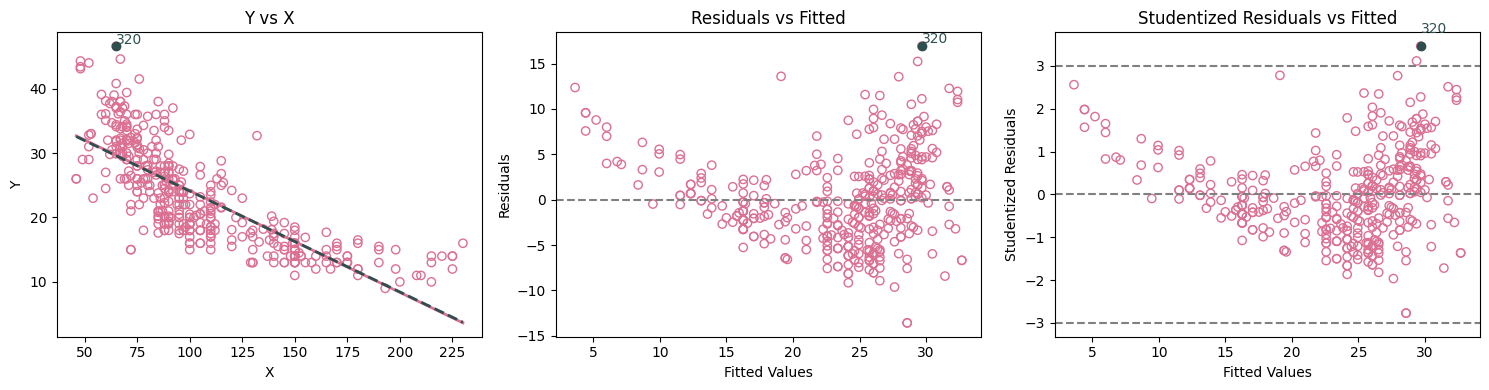

In [179]:
x = np.asarray(x).reshape(-1)
y = np.asarray(y).reshape(-1)

modelo = LinearRegression()
modelo.fit(x.reshape(-1,1), y)

y_pred = modelo.predict(x.reshape(-1,1))
residuos = y - y_pred

X = np.column_stack([np.ones(len(x)), x])
H = X @ np.linalg.inv(X.T @ X) @ X.T
h = np.diag(H)

MSE = np.sum(residuos**2) / (len(y) - 2)
stud_resid = residuos / np.sqrt(MSE * (1 - h))

outlier_pos = np.argmax(np.abs(stud_resid))

mask = np.ones(len(x), dtype=bool)
mask[outlier_pos] = False

modelo2 = LinearRegression()
modelo2.fit(x[mask].reshape(-1,1), y[mask])

y_pred2 = modelo2.predict(x.reshape(-1,1))

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.scatter(x, y, facecolors='none', edgecolors='palevioletred')
plt.scatter(x[outlier_pos], y[outlier_pos], color='darkslategrey')
plt.text(x[outlier_pos], y[outlier_pos] + 0.3, str(outlier_pos), color='darkslategrey')
xx = np.linspace(x.min(), x.max(), 100)
plt.plot(xx, modelo.coef_[0] * xx + modelo.intercept_, color='palevioletred', linewidth=2)
plt.plot(xx, modelo2.coef_[0] * xx + modelo2.intercept_, color='darkslategrey', linestyle='--', linewidth=2)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Y vs X")

plt.subplot(1,3,2)
plt.scatter(y_pred, residuos, facecolors='none', edgecolors='palevioletred')
plt.axhline(0, linestyle='--', color='gray')
plt.scatter(y_pred[outlier_pos], residuos[outlier_pos], color='darkslategrey')
plt.text(y_pred[outlier_pos], residuos[outlier_pos] + 0.3, str(outlier_pos), color='darkslategrey')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")

plt.subplot(1,3,3)
plt.scatter(y_pred, stud_resid, facecolors='none', edgecolors='palevioletred')
plt.axhline(0, linestyle='--', color='gray')
plt.axhline(3, linestyle='--', color='gray')
plt.axhline(-3, linestyle='--', color='gray')
plt.scatter(y_pred[outlier_pos], stud_resid[outlier_pos], color='darkslategrey')
plt.text(y_pred[outlier_pos], stud_resid[outlier_pos] + 0.3, str(outlier_pos), color='darkslategrey')
plt.xlabel("Fitted Values")
plt.ylabel("Studentized Residuals")
plt.title("Studentized Residuals vs Fitted")

plt.tight_layout()
plt.show()



Las gráficas muestran un outlier evidente (el punto 320), que está muy lejos del resto de los datos. En los gráficos de residuos también aparece separado y con valores extremos, lo que indica que influye mucho en el modelo y podría afectar el ajuste general.

## Problema 5: Puntos Palanca

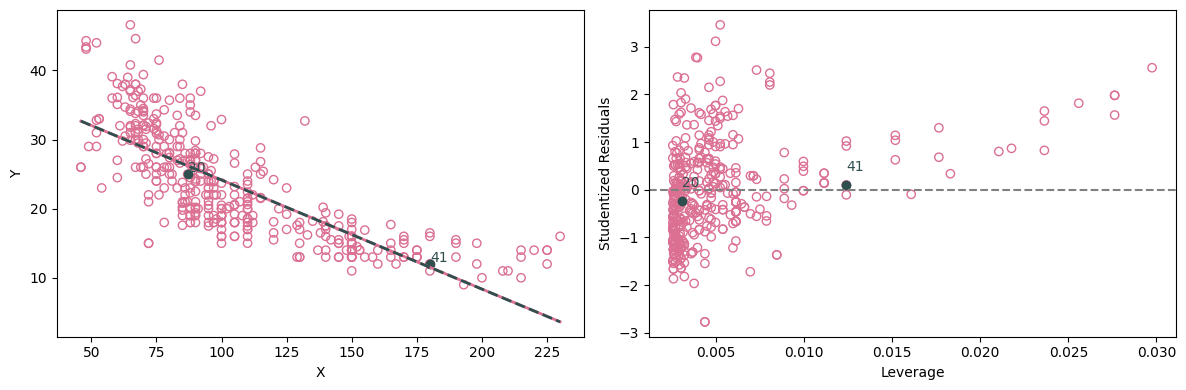

In [180]:
x = np.asarray(x).reshape(-1)
y = np.asarray(y).reshape(-1)

modelo = LinearRegression()
modelo.fit(x.reshape(-1,1), y)

y_pred = modelo.predict(x.reshape(-1,1))
residuos = y - y_pred

Xmat = np.column_stack([np.ones(len(x)), x])
H = Xmat @ np.linalg.inv(Xmat.T @ Xmat) @ Xmat.T
h = np.diag(H)

MSE = np.sum(residuos**2) / (len(y) - 2)
stud_resid = residuos / np.sqrt(MSE * (1 - h))

out20 = 20
out41 = 41

mask41 = np.ones(len(x), dtype=bool)
mask41[out41] = False

modelo2 = LinearRegression()
modelo2.fit(x[mask41].reshape(-1,1), y[mask41])

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(x, y, facecolors='none', edgecolors='palevioletred')
plt.scatter(x[out20], y[out20], color='darkslategrey')
plt.text(x[out20], y[out20] + 0.3, "20", color='darkslategrey')
plt.scatter(x[out41], y[out41], color='darkslategrey')
plt.text(x[out41], y[out41] + 0.3, "41", color='darkslategrey')
xx = np.linspace(x.min(), x.max(), 200)
plt.plot(xx, modelo.intercept_ + modelo.coef_[0] * xx, color='palevioletred', linewidth=2)
plt.plot(xx, modelo2.intercept_ + modelo2.coef_[0] * xx, color='darkslategrey', linestyle='--', linewidth=2)
plt.xlabel("X")
plt.ylabel("Y")

plt.subplot(1,2,2)
plt.scatter(h, stud_resid, facecolors='none', edgecolors='palevioletred')
plt.axhline(0, linestyle='--', color='gray')
plt.scatter(h[out20], stud_resid[out20], color='darkslategrey')
plt.text(h[out20], stud_resid[out20] + 0.3, "20", color='darkslategrey')
plt.scatter(h[out41], stud_resid[out41], color='darkslategrey')
plt.text(h[out41], stud_resid[out41] + 0.3, "41", color='darkslategrey')
plt.xlabel("Leverage")
plt.ylabel("Studentized Residuals")

plt.tight_layout()
plt.show()



Las gráficas muestran que algunos puntos, como los marcados (por ejemplo, el 20 y el 41), tienen valores de leverage más altos que la mayoría. Esto significa que están en zonas poco pobladas del eje X y, por lo tanto, pueden influir más en la forma de la recta de regresión. Aunque sus residuos no son extremos, sí destacan por su posición y conviene revisarlos porque podrían afectar el ajuste del modelo.

## Problema 6: Colinealidad

Text(0, 0.5, 'MPG')

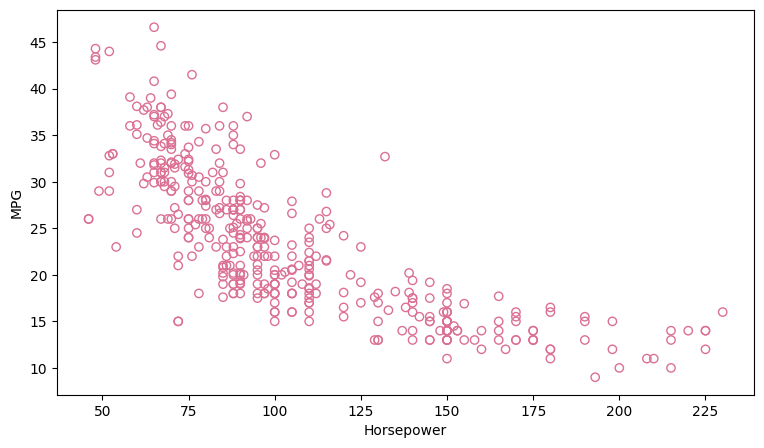

In [181]:
x = np.asarray(x).reshape(-1)
y = np.asarray(y).reshape(-1)

plt.figure(figsize=(9,5))

plt.scatter(x, y, facecolors='none', edgecolors='palevioletred')
plt.xlabel("Horsepower")
plt.ylabel("MPG")


La gráfica muestra una relación claramente negativa entre horsepower y MPG: a medida que aumenta la potencia, el rendimiento de combustible disminuye. Esta relación tan marcada indica una fuerte asociación entre ambas variables, lo que sugiere que podrían estar altamente colineadas con otras variables relacionadas con el tamaño o desempeño del vehículo. En modelos de regresión, esta colinealidad puede hacer que algunas variables aporten información redundante.